In [38]:
!pip install matplotlib

     |################################| 12.4 MB 4.6 MB/s eta 0:00:01    |#####################           | 8.2 MB 4.6 MB/s eta 0:00:01
     |################################| 88 kB 885 kB/s s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from src.helper import accuracy_scores
from src.confusion_df import render_mpl_table
from src.confusion_df import confusion_df

In [ ]:
"""
download BERT Uncased and then decompress the zip file:

wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip && unzip uncased_L-12_H-768_A-12.zip
"""

In [11]:
!pip install bert-serving-server

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [12]:
!pip install bert-serving-client

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
# start bert server from command line
# !bert-serving-start -model_dir uncased_L-12_H-768_A-12 -num_worker=2 -max_seq_len 500

"""
in case you need to restart server...

First, do a ps -x to find out the PID of the process you want killed
I restart the server through checking running python processes and kill it.
ps ax | grep python # this command will list the python process backend.
kill -9 pid # choose the running processes to kill ex.  kill -9 14204
"""

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()
bucket='hate-speech'
data_key = 'GabHateCorpus_annotations.tsv'
data_location = 's3://{}/{}'.format(bucket, data_key)

df=pd.read_csv(data_location, sep='\t')

In [3]:
df.head(1)

,ID,Annotator,Text,Hate,HD,CV,VO,REL,RAE,SXO,GEN,IDL,NAT,POL,MPH,EX,IM
0,27044,4,Ah the PSYOPS antifa crew is back. That’s how ...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
X = df['Text']
y = df['Hate']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
#test connection

from bert_serving.client import BertClient
# make a connection with the BERT server using it's ip address; do not give any ip if same computer
bc = BertClient()
# get the embedding
embedding = bc.encode(["I love data science and natural language processing."])
# check the shape of embedding, it should be 1x768
print(embedding.shape)

KeyboardInterrupt: 

In [25]:
from bert_serving.client import BertClient

# make a connection with the BERT server using it's ip address
bc = BertClient()

In [26]:
# get the embedding for train and val sets
X_train_bert = bc.encode(X_train.tolist())
X_test_bert = bc.encode(X_test.tolist())

In [27]:
# LR model
model_bert = LogisticRegression()
# train
model_bert = model_bert.fit(X_train_bert, y_train)
# predict
pred_bert = model_bert.predict(X_test_bert)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [28]:
print(accuracy_score(y_test, pred_bert))

0.8773835663931584


In [35]:
proba_true_BERT = model_bert.predict_proba(X_test_bert)[:,1]

In [36]:
np.savetxt('data/bert_y_pred_proba.txt', proba_true_BERT)
np.savetxt('data/bert_y_pred.txt', pred_bert)
np.savetxt('data/bert_y_test.txt', y_test)

In [33]:
pred_bert[1]

1

In [45]:
a, r, p, mse = accuracy_scores(y_test, pred_bert)
a, r, p

(0.877, 0.181, 0.53)

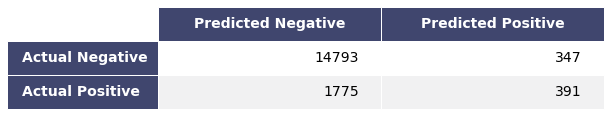

In [50]:
df_ = confusion_df(y_test, pred_bert)
fig, ax = render_mpl_table(df_)
fig.show()
fig.savefig('img/bert_lr_conf_mat.png', bbox_inches='tight')